In [ ]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer, BlipProcessor, BlipForConditionalGeneration

### Base Model Text Captioning of Minimap ###

In [2]:
image = Image.open("C:/Users/Andrew Jeon/OneDrive/Desktop/ICTAM/data/images/art1_019.jpg").convert("RGB")

#processor class internally pre-processes the image and BPE tokenizes the caption
processor_gb = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model_gb = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

imgtensor_gb = processor_gb(images=image, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_gb = model_gb.generate(pixel_values=imgtensor_gb, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_gb = processor_gb.batch_decode(txttokens_gb, skip_special_tokens=True)[0] #decode token id's into words



#processor class internally pre-processes the image and BPE tokenizes the caption
processor_bb = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_bb = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

imgtensor_bb = processor_bb(images=image, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_bb = model_bb.generate(pixel_values=imgtensor_bb, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_bb = processor_bb.batch_decode(txttokens_bb, skip_special_tokens=True)[0] #decode token id's into words

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Text(0.5, 1.0, 'BLIP-base-image-captioning caption')

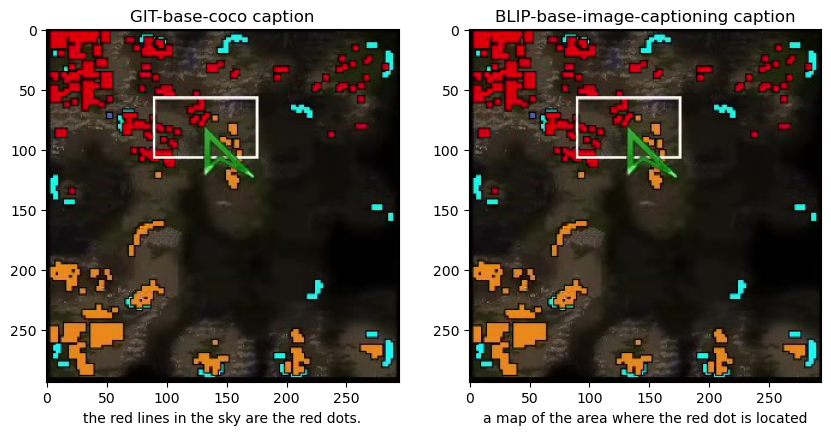

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(image))
plt.xlabel(caption_gb)
plt.title('GIT-base-coco caption')

plt.subplot(1, 2, 2)
plt.imshow(np.asarray(image))
plt.xlabel(caption_bb)
plt.title('BLIP-base-image-captioning caption')

In [39]:
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

processor_gb = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model_gb = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

for name, param in model_gb.named_parameters():
    if param.requires_grad:
        print(name)

git.embeddings.word_embeddings.weight
git.embeddings.position_embeddings.weight
git.embeddings.LayerNorm.weight
git.embeddings.LayerNorm.bias
git.image_encoder.vision_model.embeddings.class_embedding
git.image_encoder.vision_model.embeddings.patch_embedding.weight
git.image_encoder.vision_model.embeddings.position_embedding.weight
git.image_encoder.vision_model.pre_layrnorm.weight
git.image_encoder.vision_model.pre_layrnorm.bias
git.image_encoder.vision_model.encoder.layers.0.self_attn.k_proj.weight
git.image_encoder.vision_model.encoder.layers.0.self_attn.k_proj.bias
git.image_encoder.vision_model.encoder.layers.0.self_attn.v_proj.weight
git.image_encoder.vision_model.encoder.layers.0.self_attn.v_proj.bias
git.image_encoder.vision_model.encoder.layers.0.self_attn.q_proj.weight
git.image_encoder.vision_model.encoder.layers.0.self_attn.q_proj.bias
git.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.weight
git.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.

Note: you may need to restart the kernel to use updated packages.


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

C:\Users\Andrew Jeon\AppData\Local\Temp\ipykernel_16256\4118503748.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,9.299400
20,6.878200
30,5.736900
40,4.638300
50,3.919400
60,3.038700
70,2.336800
80,1.820500
90,1.169900
100,1.174400


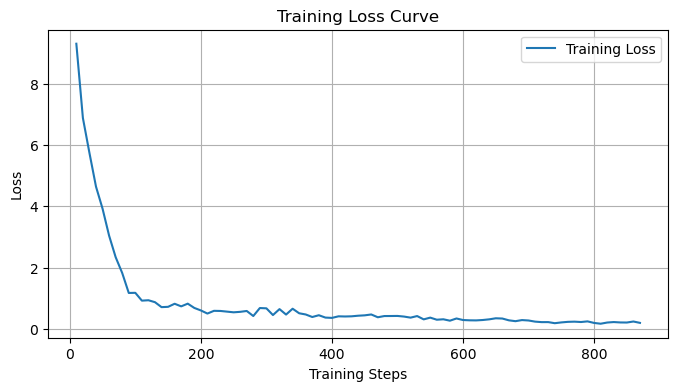

[]

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset

image_dir = r"C:\Users\Andrew Jeon\OneDrive\Desktop\ICTAM\data\images"
with open(r"C:\Users\Andrew Jeon\OneDrive\Desktop\ICTAM\data\minimap_annot.json", "r") as f:
    annotations = json.load(f)

def preprocess(example):
    image_path = os.path.join(image_dir, example['image'])
    image = Image.open(image_path).convert("RGB")

    encoding = processor(
        images=image,
        text=example['text_output'],
        padding="max_length",
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    encoding["labels"] = encoding["input_ids"].clone()
    return encoding

train_data = annotations[:700]
test_data = annotations[700:]
train_dataset = Dataset.from_list(train_data).map(preprocess)
test_dataset = Dataset.from_list(test_data).map(preprocess)

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")



training_args = TrainingArguments(
    output_dir="./blip-finetuned-checkpoints",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_steps=10,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
)

trainer.train()

logs = trainer.state.log_history
train_steps = []
train_losses = []
for log in logs:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


# === 8. Save fine-tuned model ===
model.save_pretrained("blip-finetuned-model")
processor.save_pretrained("blip-finetuned-model")

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

C:\Users\Andrew Jeon\AppData\Local\Temp\ipykernel_16256\125526840.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,9.380100
20,7.300000
30,6.229400
40,5.301200
50,4.761300
60,3.939300
70,3.349200
80,2.858300
90,2.038800
100,1.859000


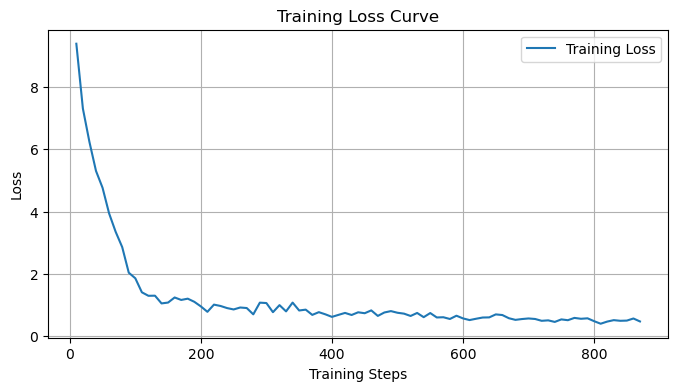

[]

In [ ]:
from transformers import GitProcessor, GitForCausalLM, TrainingArguments, Trainer
from datasets import Dataset

image_dir = r"C:\Users\Andrew Jeon\OneDrive\Desktop\ICTAM\data\images"
with open(r"C:\Users\Andrew Jeon\OneDrive\Desktop\ICTAM\data\minimap_annot.json", "r") as f:
    annotations = json.load(f)

def preprocess(example):
    image_path = os.path.join(image_dir, example['image'])
    image = Image.open(image_path).convert("RGB")

    encoding = processor(
        images=image,
        text=example['text_output'],
        padding="max_length",
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    encoding["labels"] = encoding["input_ids"].clone()
    return encoding

train_data = annotations[:700]
test_data = annotations[700:]
train_dataset = Dataset.from_list(train_data).map(preprocess)
test_dataset = Dataset.from_list(test_data).map(preprocess)

processor = GitProcessor.from_pretrained("microsoft/git-base-coco")
model = GitForCausalLM.from_pretrained("microsoft/git-base-coco")


training_args = TrainingArguments(
    output_dir="./git-finetuned-checkpoints",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_steps=10,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
)
trainer.train()

logs = trainer.state.log_history
train_steps = []
train_losses = []
for log in logs:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])

plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Save model
model.save_pretrained("git-finetuned-model")
processor.save_pretrained("git-finetuned-model")

In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration, GitProcessor, GitForCausalLM
image1_path = "C:/Users/Andrew Jeon/OneDrive/Desktop/ICTAM/data/images/art9_009.jpg"
image1 = Image.open(image1_path).convert("RGB")


model_gf = GitForCausalLM.from_pretrained("git-finetuned-model")
processor_gf = GitProcessor.from_pretrained("git-finetuned-model")

imgtensor_gf = processor_gf(images=image1, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_gf = model_gf.generate(pixel_values=imgtensor_gf, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_gf1 = processor_gf.batch_decode(txttokens_gf, skip_special_tokens=True)[0] #decode token id's into words



model_bf = BlipForConditionalGeneration.from_pretrained("blip-finetuned-model")
processor_bf = BlipProcessor.from_pretrained("blip-finetuned-model")

imgtensor_bf = processor_bf(images=image1, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_bf = model_bf.generate(pixel_values=imgtensor_bf, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_bf1 = processor_bf.batch_decode(txttokens_bf, skip_special_tokens=True)[0] #decode token id's into words

In [8]:
image2_path = "C:/Users/Andrew Jeon/OneDrive/Desktop/ICTAM/data/images/art9_012.jpg"
image2 = Image.open(image2_path).convert("RGB")

imgtensor_gf = processor_gf(images=image2, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_gf = model_gf.generate(pixel_values=imgtensor_gf, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_gf2 = processor_gf.batch_decode(txttokens_gf, skip_special_tokens=True)[0] #decode token id's into words

imgtensor_bf = processor_bf(images=image2, return_tensors="pt").pixel_values #returns image values as tensor
txttokens_bf = model_bf.generate(pixel_values=imgtensor_bf, max_length=50) #image encoder encodes image tensor --> language decoder  generates text tokens using image tokens as context
caption_bf2 = processor_bf.batch_decode(txttokens_bf, skip_special_tokens=True)[0] #decode token id's into words

In [10]:
print(caption_gf1)
print(caption_bf1)

. has bases orange two and has but has an on map.
orange. orange has a third base while blue has only two.


Text(0.5, 1.0, 'blip-finetuned-model caption')

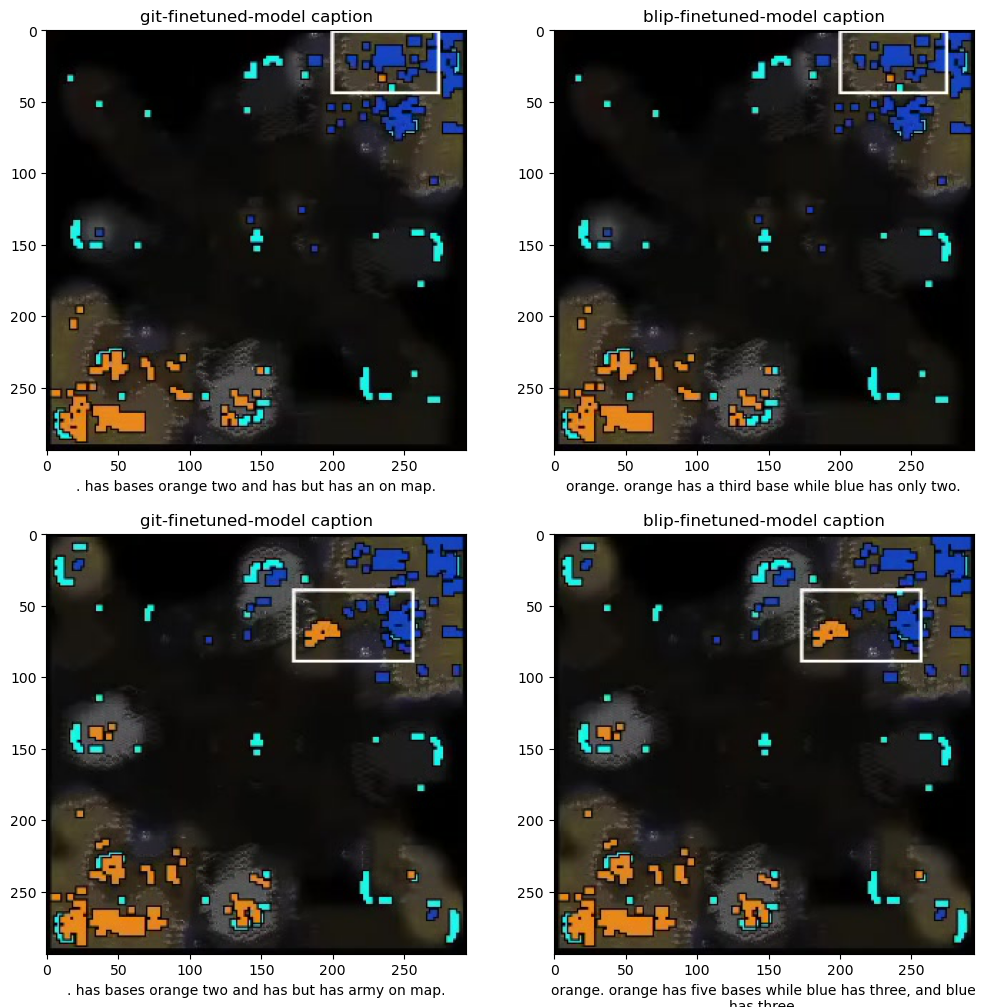

In [9]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(np.asarray(image1))
plt.xlabel(caption_gf1, wrap=True)
plt.title('git-finetuned-model caption')

plt.subplot(2, 2, 2)
plt.imshow(np.asarray(image1))
plt.xlabel(caption_bf1, wrap=True)
plt.title('blip-finetuned-model caption')

plt.subplot(2, 2, 3)
plt.imshow(np.asarray(image2))
plt.xlabel(caption_gf2, wrap=True)
plt.title('git-finetuned-model caption')

plt.subplot(2, 2, 4)
plt.imshow(np.asarray(image2))
plt.xlabel(caption_bf2, wrap=True)
plt.title('blip-finetuned-model caption')


### Evaluation

In [ ]:
from evaluate import load
from torch.utils.data import DataLoader
import torch
from datasets import Dataset

wer = load("wer")
bleu = load("bleu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bf = model_bf.to(device).eval()
model_gf = model_gf.to(device).eval()

loader = DataLoader(test_dataset.with_format("torch"), batch_size=4)
blip_preds, git_preds, refs = [], [], []

with torch.no_grad():
    for batch in loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # BLIP
        out_blip = model_bf.generate(pixel_values, max_length=50)
        blip_decoded = processor_bf.batch_decode(out_blip, skip_special_tokens=True)
        blip_preds += blip_decoded

        # GIT
        cls_token_id = processor_gf.tokenizer.cls_token_id
        input_ids = torch.full((pixel_values.size(0), 1), cls_token_id, device=device)
        out_git = model_gf.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
        git_decoded = processor_gf.batch_decode(out_git, skip_special_tokens=True)
        git_preds += git_decoded

        # Ground truth
        refs += processor_gf.batch_decode(labels, skip_special_tokens=True)

refs_bleu = [[ref] for ref in refs]

# WER Evaluation
print("BLIP BLEU:", bleu.compute(predictions=blip_preds, references=refs_bleu))
print("GIT  BLEU:", bleu.compute(predictions=git_preds, references=refs_bleu))
print("BLIP WER:", wer.compute(predictions=blip_preds, references=refs))
print("GIT  WER:", wer.compute(predictions=git_preds, references=refs))


Map:   0%|          | 0/23 [00:00<?, ? examples/s]

NameError: name 'processor' is not defined

KeyboardInterrupt: 

In [28]:
from PIL import Image
import torch
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bf.eval()
model_gf.eval()

captions_bf = {}
captions_gf = {}

for annot in tqdm(test_data):  # test_data is your list of dicts
    img_path = os.path.join(image_dir, annot["image"])
    img = Image.open(img_path).convert("RGB")

    # BLIP caption
    inputs = processor_bf(images=img, return_tensors="pt").to(device)
    out = model_bf.generate(**inputs, max_length=50)
    caption_bf = processor_bf.batch_decode(out, skip_special_tokens=True)[0]
    captions_bf[annot["image"]] = caption_bf

    # GIT caption
    inputs = processor_gf(images=img, return_tensors="pt").to(device)
    out = model_gf.generate(**inputs, max_length=50)
    caption_gf = processor_gf.batch_decode(out, skip_special_tokens=True)[0]
    captions_gf[annot["image"]] = caption_gf


100%|██████████| 23/23 [00:12<00:00,  1.81it/s]


In [32]:
with open("C:/Users/Andrew Jeon/OneDrive/Desktop/ICTAM/data/minimap_annot.json", "r") as f:
    annotations = json.load(f)

gt_judgements = {}

test_imgs = []
for i in range(2, 25):
    test_imgs.append(f"art9_{i:03d}.jpg")

for entry in annotations:
    if entry["image"] in test_imgs:
        first_word = entry["text_output"].split('.')[0].lower().strip()
        gt_judgements[entry["image"]] = first_word

blip_judgements = {
    k: v.split('.')[0].strip().lower()
    for k, v in captions_bf.items()
}



matches = 0
total = 0
for img in gt_judgements:
    if img in blip_judgements:
        total += 1
        if blip_judgements[img] == gt_judgements[img]:
            matches += 1



print(blip_judgements)
print(gt_judgements)
print(f"Match count: {matches}/{total} = {matches / total:.2f}")


{'art9_002.jpg': 'draw', 'art9_003.jpg': 'draw', 'art9_004.jpg': 'draw', 'art9_005.jpg': 'draw', 'art9_006.jpg': 'draw', 'art9_007.jpg': 'draw', 'art9_008.jpg': 'blue', 'art9_009.jpg': 'orange', 'art9_010.jpg': 'orange', 'art9_011.jpg': 'orange', 'art9_012.jpg': 'orange', 'art9_013.jpg': 'orange', 'art9_014.jpg': 'orange', 'art9_015.jpg': 'orange', 'art9_016.jpg': 'orange', 'art9_017.jpg': 'orange', 'art9_018.jpg': 'orange', 'art9_019.jpg': 'orange', 'art9_020.jpg': 'orange', 'art9_021.jpg': 'orange', 'art9_022.jpg': 'orange', 'art9_023.jpg': 'orange', 'art9_024.jpg': 'orange'}
{'art9_002.jpg': 'draw', 'art9_003.jpg': 'draw', 'art9_004.jpg': 'draw', 'art9_005.jpg': 'draw', 'art9_006.jpg': 'draw', 'art9_007.jpg': 'draw', 'art9_008.jpg': 'draw', 'art9_009.jpg': 'draw', 'art9_010.jpg': 'draw', 'art9_011.jpg': 'draw', 'art9_012.jpg': 'orange', 'art9_013.jpg': 'draw', 'art9_014.jpg': 'draw', 'art9_015.jpg': 'orange', 'art9_016.jpg': 'orange', 'art9_017.jpg': 'orange', 'art9_018.jpg': 'draw'